<a href="https://colab.research.google.com/github/alexandrgsv/stock_prediction_models/blob/main/%22MMVB_LSTM_ub_lb_CWB_pareto_front_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K


In [2]:
# Load the data
#data = pd.read_csv('https://drive.google.com/uc?id=18RjIb6w6OXLPeKYJ-UJKUNtmY71RpP5D', header=0, usecols=['<DATE>', '<CLOSE>'], date_parser=True)
data = pd.read_csv('https://drive.google.com/uc?id=18RjIb6w6OXLPeKYJ-UJKUNtmY71RpP5D',
                   header=0, 
                   usecols=['<DATE>', '<CLOSE>'], 
                   parse_dates=['<DATE>'], 
                   date_parser=lambda x: pd.to_datetime(x, format='%d/%m/%y'))

df = data[['<DATE>', '<CLOSE>']].copy()

In [3]:
df = df.sort_values('<DATE>')
df = df.reset_index(drop=True)
#df = df.set_index('<DATE>').sort_index()



In [4]:
# Define the window size and the forecast horizon
window_size = 60
forecast_horizon = 30


In [5]:
# Split the data into training and test sets
train_size = int(len(df) * 0.8)
train = df[:train_size]
test = df[train_size-window_size:]

In [6]:
# Scale the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train['<CLOSE>'].values.reshape(-1, 1))
test_scaled = scaler.transform(test['<CLOSE>'].values.reshape(-1, 1))


In [ ]:
#def coverage_loss(y_true, y_pred):
#    alpha = 10 # set the confidence level
#    w = K.abs(y_pred[:, 1] - y_pred[:, 0]) # calculate the coverage width
#    e = y_true[:, 0] - y_pred[:, 0] # calculate the prediction error
#    return K.mean(K.maximum((w),0)) + K.mean(K.maximum((alpha * K.abs(e)), 0))


In [7]:
import tensorflow_probability as tfp

def coverage_loss(y_true, y_pred, width):
    q = (1 - width) / 2
    e = y_true - y_pred
    coverage = K.cast(K.abs(e) < tfp.stats.percentile(K.abs(e), q + width * 100), dtype='float32')
    coverage_error = K.mean((1 - coverage) * K.abs(e))
    prediction_error = K.mean(coverage * K.abs(e))
    return coverage_error + prediction_error


In [8]:
# Create the training and test data using the sliding window approach
X_train = []
y_train = []
for i in range(window_size, len(train_scaled)):
    X_train.append(train_scaled[i-window_size:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test = []
y_test = []
for i in range(window_size, len(test_scaled)-forecast_horizon):
    X_test.append(test_scaled[i-window_size:i, 0])
    y_test.append(test_scaled[i:i+forecast_horizon, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [12]:
# Split training data into two complementary parts
from sklearn.model_selection import train_test_split
X1_train, X2_train, y1_train, y2_train = train_test_split(X_train, y_train, test_size=0.5)

In [9]:
# Define the model
model = Sequential([
    LSTM(units=10, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=forecast_horizon*2, activation='linear')
])




In [10]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='loss', patience=5, mode='min', verbose=1)


In [20]:
def fitness_function(params, X_train, y_train, X_val, y_val):
  lr = params[0]
  batch_size = int(params[1])
  epochs = int(params[2])
  model.compile(optimizer=Adam(learning_rate=lr), loss=lambda y_true, y_pred: coverage_loss(y_true, y_pred, width=0.1))
  # Train the model
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stop])
  return -history.history['val_loss'][-1]


In [13]:
# Split training data into two complementary parts
from sklearn.model_selection import train_test_split
X1_train, X2_train, y1_train, y2_train = train_test_split(X_train, y_train, test_size=0.5)

In [22]:
import random

# Step 1:

# Set the PSO parameters
lb = [1e-5, 16, 2]  # Lower bounds for learning rate, batch size, and epochs
ub = [1e-2, 64, 3]  # Upper bounds for learning rate, batch size, and epochs

# Number of particles and iterations
n_particles = 10
n_iterations = 1
n_dimensions = 3


# Step 2: Initialize particle swarm
class Particle:
    def __init__(self):
        self.position = np.random.uniform(low=lb, high=ub, size=(n_dimensions))
        self.velocity = np.random.uniform(low=-1*(np.array(ub)-np.array(lb)), high=np.array(ub)-np.array(lb), size=(n_dimensions))
        self.pbest_position = self.position.copy()
        self.pbest_fitness = None
        self.domination_count = 0
        self.dominated_solutions = []
        self.fitness = (0,0)

swarm = [Particle() for _ in range(n_particles)]
gbest_position = None
gbest_fitness = None

# Step 3-6: Evaluate, update, and iterate
for i in range(n_iterations):
    for p in swarm:
        # Evaluate fitness
        fitness1 = fitness_function(p.position, X1_train, y1_train, X_test, y_test)
        fitness2 = fitness_function(p.position, X2_train, y2_train, X_test, y_test)
        p.fitness = (fitness1, fitness2)

        # Update personal best
        if p.pbest_fitness is None or p.fitness < p.pbest_fitness:
            p.pbest_position = p.position.copy()
            p.pbest_fitness = p.fitness

        # Update global best
        if gbest_fitness is None or p.fitness < gbest_fitness:
            gbest_position = p.position.copy()
            gbest_fitness = p.fitness

        # Update domination count and dominated solutions
        p.domination_count = 0
        p.dominated_solutions = []
        for q in swarm:
            if p.fitness < q.fitness:
                p.dominated_solutions.append(q)
            elif q.fitness < p.fitness:
                p.domination_count += 1

        # Update velocity and position
        for j in range(n_dimensions):
            rp = random.uniform(0, 1)
            rg = random.uniform(0, 1)
            vel_cognitive = 2 * rp * (p.pbest_position[j] - p.position[j])
            vel_social = 2 * rg * (gbest_position[j] - p.position[j])
            p.velocity[j] = 0.5 * p.velocity[j] + vel_cognitive + vel_social
            p.position[j] += p.velocity[j]

    # Step 7: Select non-dominated solutions
    pareto_front = []
    for p in swarm:
        if p.domination_count == 0:
            pareto_front.append(p)

# Print Pareto front
for p in pareto_front:
    print(p.position, p.fitness)

Epoch 1/2
69/69 [==============================] - 22s 127ms/step - loss: 0.0238 - val_loss: 0.0149
Epoch 2/2
69/69 [==============================] - 7s 95ms/step - loss: 0.0221 - val_loss: 0.0109
Epoch 1/2
69/69 [==============================] - 15s 130ms/step - loss: 0.0225 - val_loss: 0.0129
Epoch 2/2
69/69 [==============================] - 7s 103ms/step - loss: 0.0220 - val_loss: 0.0158
Epoch 1/2
51/51 [==============================] - 13s 141ms/step - loss: 0.0197 - val_loss: 0.0112
Epoch 2/2
51/51 [==============================] - 5s 95ms/step - loss: 0.0191 - val_loss: 0.0116
Epoch 1/2
51/51 [==============================] - 14s 153ms/step - loss: 0.0193 - val_loss: 0.0101
Epoch 2/2
51/51 [==============================] - 5s 97ms/step - loss: 0.0191 - val_loss: 0.0103
Epoch 1/2
53/53 [==============================] - 15s 147ms/step - loss: 0.0185 - val_loss: 0.0100
Epoch 2/2
53/53 [==============================] - 5s 96ms/step - loss: 0.0187 - val_loss: 0.0104
Epoch 1/2

In [30]:
pareto_front_fitness = []

for p in pareto_front:
    pareto_front_fitness.append(p.fitness)

print(pareto_front_fitness)

[(-0.01091862004250288, -0.015781041234731674), (-0.011629821732640266, -0.010290438309311867), (-0.011683699674904346, -0.011711283586919308), (-0.012953815050423145, -0.011728035286068916), (-0.013921636156737804, -0.01214668434113264)]


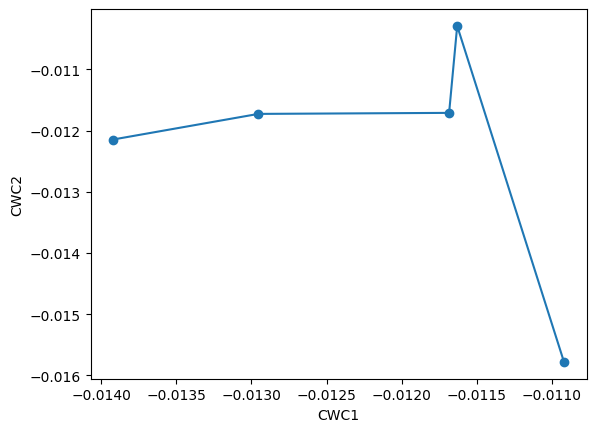

In [34]:
# extract the x and y coordinates from the tuples
x = [p[0] for p in pareto_front_fitness]
y = [p[1] for p in pareto_front_fitness]

# create a line plot with dots at each point on the x and y coordinates
plt.plot(x, y, 'o-')

# set the labels for the x and y axes
plt.xlabel('CWC1')
plt.ylabel('CWC2')

# show the plot
plt.show()


In [23]:
# Make predictions
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

31/31 [==============================] - 2s 26ms/step


In [24]:
np.mean(y_test)

2953.4742129629635

In [25]:
np.std(y_test)

601.9852360466086

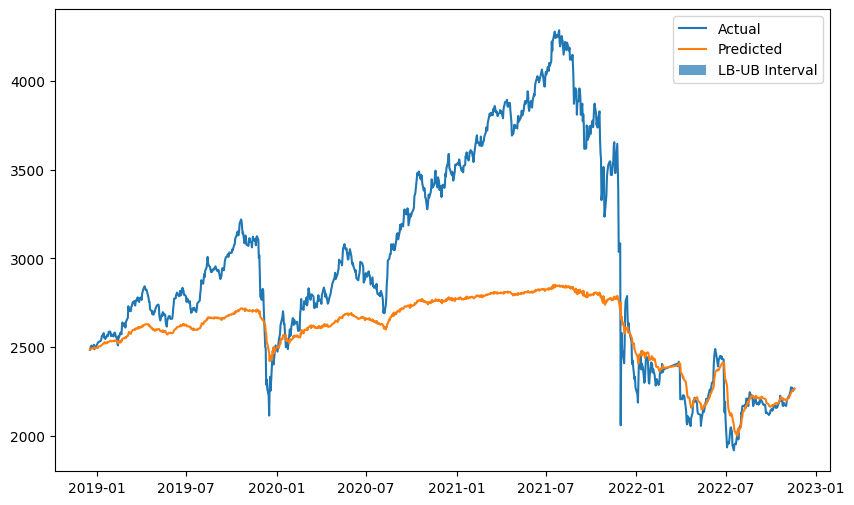

In [26]:
# Plot the actual and predicted stock prices with the upper and lower bounds
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(test['<DATE>'][:-forecast_horizon-60], y_test[:, 0], label='Actual')
ax.plot(test['<DATE>'][:-forecast_horizon-60], y_pred[:, 0], label='Predicted')
ax.fill_between(test['<DATE>'][:-forecast_horizon-60], y_pred[:, 0], y_pred[:, 1], alpha=0.7, label='LB-UB Interval')
ax.legend()
plt.show()


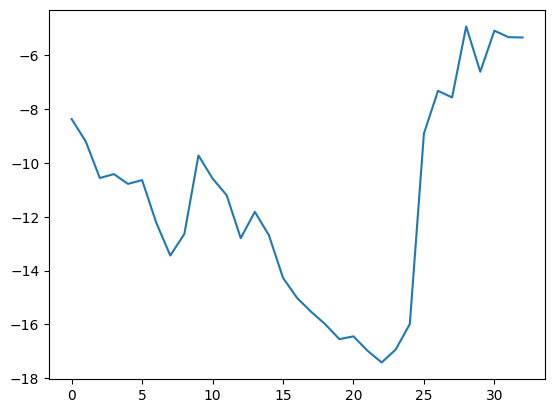

In [ ]:
# the interval width
plt.plot(y_pred[::forecast_horizon, 1]-y_pred[::forecast_horizon, 0])

In [ ]:
# Create the training data using the sliding window approach for all the data available
train_scaled = scaler.fit_transform(df['<CLOSE>'].values.reshape(-1, 1))

X_train = []
y_train = []
for i in range(window_size, len(train_scaled)):
    X_train.append(train_scaled[i-window_size:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)


In [ ]:
model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[early_stop])

Epoch 1/100
155/155 [==============================] - 15s 99ms/step - loss: 0.0199
Epoch 2/100
155/155 [==============================] - 16s 105ms/step - loss: 0.0183
Epoch 3/100
155/155 [==============================] - 16s 101ms/step - loss: 0.0187
Epoch 4/100
155/155 [==============================] - 16s 100ms/step - loss: 0.0187
Epoch 5/100
155/155 [==============================] - 15s 98ms/step - loss: 0.0179
Epoch 6/100
155/155 [==============================] - 16s 103ms/step - loss: 0.0167
Epoch 7/100
155/155 [==============================] - 15s 100ms/step - loss: 0.0172
Epoch 8/100
155/155 [==============================] - 16s 100ms/step - loss: 0.0177
Epoch 9/100
155/155 [==============================] - 16s 101ms/step - loss: 0.0169
Epoch 10/100
155/155 [==============================] - 15s 97ms/step - loss: 0.0169
Epoch 11/100
155/155 [==============================] - 15s 97ms/step - loss: 0.0174
Epoch 11: early stopping


In [ ]:
last_window_forecast = scaler.inverse_transform(model.predict(X_test[-window_size].reshape(-1,1)))

2/2 [==============================] - 1s 7ms/step


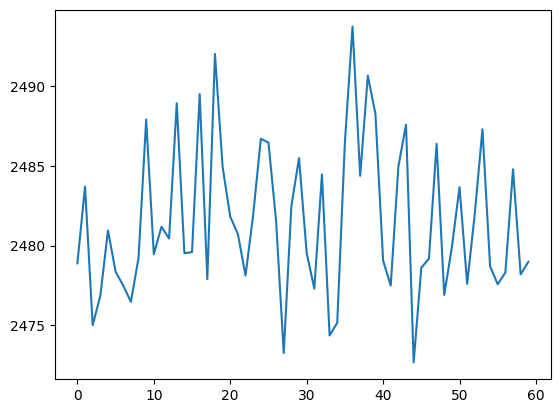

In [ ]:
plt.plot(last_window_forecast[1])

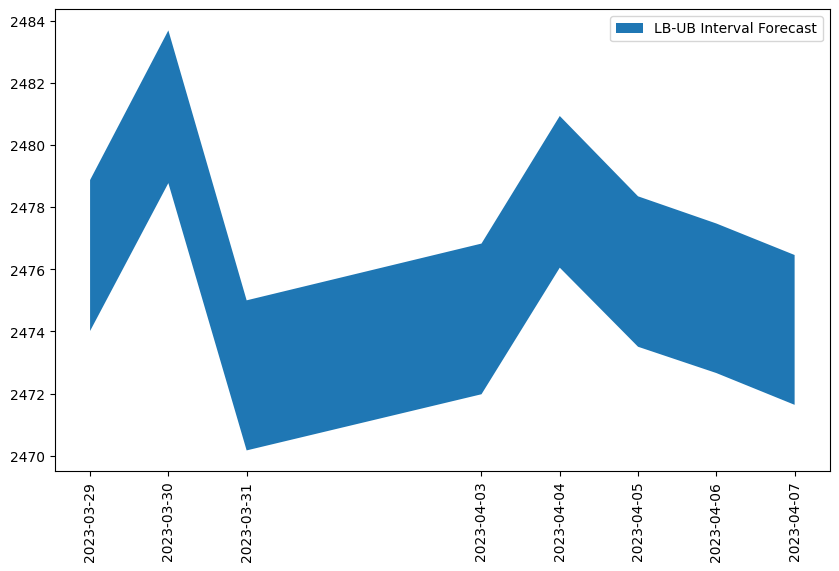

In [ ]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

start_date = test['<DATE>'].iloc[-1].date()
N = 10 # replace with the number of dates you want to generate

dates = []
for i in range(N):
    date = start_date + datetime.timedelta(days=i)
    day = date.weekday()
    if day < 5: # Add only weekdays
        dates.append(date)

fig, ax = plt.subplots(figsize=(10, 6))
ax.fill_between(dates, last_window_forecast[1,:len(dates)], last_window_forecast[0, :len(dates)], alpha=1, label='LB-UB Interval Forecast')
# filter out weekends from dates list
weekdays = [date for date in dates if date.weekday() < 5]
weekdays_fmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(weekdays_fmt)
ax.set_xticks(weekdays)

# rotate the x-axis tick labels
plt.xticks(rotation=90)
ax.legend()
plt.show()
